In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import torch
from utils import load_ckpt, visualize_depth
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict

torch.backends.cudnn.benchmark = True

img_wh = (400, 400)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hparams,full_dataset) -> None:
        super(Net,self).__init__()
        self.hparams = hparams
        self.full_dataset = full_dataset
#         self.loss = loss_dict['nerfw'](coef=1)

        self.models_to_train = []
        self.embedding_xyz = PosEmbedding(hparams.N_emb_xyz-1, hparams.N_emb_xyz)
        self.embedding_dir = PosEmbedding(hparams.N_emb_dir-1, hparams.N_emb_dir)
        self.embeddings = {'xyz': self.embedding_xyz,
                           'dir': self.embedding_dir}

        if hparams.encode_a:
            self.embedding_a = torch.nn.Embedding(hparams.N_vocab, hparams.N_a)
            self.embeddings['a'] = self.embedding_a
            self.models_to_train += [self.embedding_a]
        if hparams.encode_t:
            self.embedding_t = torch.nn.Embedding(hparams.N_vocab, hparams.N_tau)
            self.embeddings['t'] = self.embedding_t
            self.models_to_train += [self.embedding_t]

        self.nerf_coarse = NeRF('coarse',
                                in_channels_xyz=6*hparams.N_emb_xyz+3,
                                in_channels_dir=6*hparams.N_emb_dir+3)
        self.models = {'coarse': self.nerf_coarse}
        if hparams.N_importance > 0:
            self.nerf_fine = NeRF('fine',
                                  in_channels_xyz=6*hparams.N_emb_xyz+3,
                                  in_channels_dir=6*hparams.N_emb_dir+3,
                                  encode_appearance=hparams.encode_a,
                                  in_channels_a=hparams.N_a,
                                  encode_transient=hparams.encode_t,
                                  in_channels_t=hparams.N_tau,
                                  beta_min=hparams.beta_min)
            self.models['fine'] = self.nerf_fine
        self.models_to_train += [self.models]

    def forward(self, rays, ts):
        B = rays.shape[0]
        results = defaultdict(list)
        for i in range(0, B, self.hparams.chunk):
            rendered_ray_chunks = \
                render_rays(self.models,
                            self.embeddings,
                            rays[i:i+self.hparams.chunk],
                            ts[i:i+self.hparams.chunk],
                            self.hparams.N_samples,
                            self.hparams.use_disp,
                            self.hparams.perturb,
                            self.hparams.noise_std,
                            self.hparams.N_importance,
                            self.hparams.chunk, # chunk size is effective in val mode
                            self.full_dataset.white_back)

            for k, v in rendered_ray_chunks.items():
                results[k] += [v]

        for k, v in results.items():
            results[k] = torch.cat(v, 0)
        return results

In [43]:
@torch.no_grad()
def f(rays, ts, model_,model_params):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, hparams.chunk):
        rendered_ray_chunks = \
            render_rays(model_,
                        model_params.embeddings,
                        rays[i:i+hparams.chunk],
                        ts[i:i+hparams.chunk],
                        hparams.N_samples,
                        hparams.use_disp,
                        0,
                        0,
                        hparams.N_importance,
                        hparams.chunk,
                        train_dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [2]:
import argparse
parser = argparse.ArgumentParser()

parser.add_argument('--root_dir', type=str, required=False,
                    help='root directory of dataset')
parser.add_argument('--dataset_name', type=str, default='blender',
                    choices=['blender', 'phototourism'],
                    help='which dataset to train/val')
# for blender
parser.add_argument('--data_perturb', nargs="+", type=str, default=[],
                    help='''what perturbation to add to data.
                            Available choices: [], ["color"], ["occ"] or ["color", "occ"]
                         ''')
parser.add_argument('--nonrandom_occ', default=False, action="store_true",
                    help='whether to use non-random occlusion')
parser.add_argument('--all_img_occ', default=False, action="store_true",
                    help='whether to add black occlusion to all images')
parser.add_argument('--occ_yaw', type=float, default=0.0,
                    help='yaw angle for selecting images for non-random occlusion')
parser.add_argument('--yaw_threshold', type=float, default=0.0,
                    help='threshold for selecting images for non-random occlusion')
parser.add_argument('--img_wh', nargs="+", type=int, default=[800, 800],
                    help='resolution (img_w, img_h) of the image')

# for phototourism
parser.add_argument('--img_downscale', type=int, default=1,
                    help='how much to downscale the images for phototourism dataset')
parser.add_argument('--use_cache', default=False, action="store_true",
                    help='whether to use ray cache (make sure img_downscale is the same)')
parser.add_argument('--use_mask', default=False, action="store_true",
                    help='use masked images')

# original NeRF parameters
parser.add_argument('--N_emb_xyz', type=int, default=10,
                    help='number of xyz embedding frequencies')
parser.add_argument('--N_emb_dir', type=int, default=4,
                    help='number of direction embedding frequencies')
parser.add_argument('--N_samples', type=int, default=64,
                    help='number of coarse samples')
parser.add_argument('--N_importance', type=int, default=128,
                    help='number of additional fine samples')
parser.add_argument('--use_disp', default=False, action="store_true",
                    help='use disparity depth sampling')
parser.add_argument('--perturb', type=float, default=1.0,
                    help='factor to perturb depth sampling points')
parser.add_argument('--noise_std', type=float, default=1.0,
                    help='std dev of noise added to regularize sigma')

# NeRF-W parameters
parser.add_argument('--N_vocab', type=int, default=100,
                    help='''number of vocabulary (number of images) 
                            in the dataset for nn.Embedding''')
parser.add_argument('--encode_a', default=False, action="store_true",
                    help='whether to encode appearance (NeRF-A)')
parser.add_argument('--N_a', type=int, default=48,
                    help='number of embeddings for appearance')
parser.add_argument('--encode_t', default=False, action="store_true",
                    help='whether to encode transient object (NeRF-U)')
parser.add_argument('--N_tau', type=int, default=16,
                    help='number of embeddings for transient objects')
parser.add_argument('--beta_min', type=float, default=0.1,
                    help='minimum color variance for each ray')

parser.add_argument('--batch_size', type=int, default=1024,
                    help='batch size')
parser.add_argument('--chunk', type=int, default=32*1024,
                    help='chunk size to split the input to avoid OOM')
parser.add_argument('--num_epochs', type=int, default=16,
                    help='number of training epochs')
parser.add_argument('--num_gpus', type=int, default=1,
                    help='number of gpus')

parser.add_argument('--ckpt_path', type=str, default=None,
                    help='pretrained checkpoint path to load')
parser.add_argument('--prefixes_to_ignore', nargs='+', type=str, default=['loss'],
                    help='the prefixes to ignore in the checkpoint state dict')

parser.add_argument('--optimizer', type=str, default='adam',
                    help='optimizer type',
                    choices=['sgd', 'adam', 'radam', 'ranger'])
parser.add_argument('--lr', type=float, default=5e-4,
                    help='learning rate')
parser.add_argument('--momentum', type=float, default=0.9,
                    help='learning rate momentum')
parser.add_argument('--weight_decay', type=float, default=0,
                    help='weight decay')
parser.add_argument('--lr_scheduler', type=str, default='steplr',
                    help='scheduler type',
                    choices=['steplr', 'cosine', 'poly'])
#### params for warmup, only applied when optimizer == 'sgd' or 'adam'
parser.add_argument('--warmup_multiplier', type=float, default=1.0,
                    help='lr is multiplied by this factor after --warmup_epochs')
parser.add_argument('--warmup_epochs', type=int, default=0,
                    help='Gradually warm-up(increasing) learning rate in optimizer')
###########################
#### params for steplr ####
parser.add_argument('--decay_step', nargs='+', type=int, default=[20],
                    help='scheduler decay step')
parser.add_argument('--decay_gamma', type=float, default=0.1,
                    help='learning rate decay amount')
###########################
#### params for poly ####
parser.add_argument('--poly_exp', type=float, default=0.9,
                    help='exponent for polynomial learning rate decay')
###########################

parser.add_argument('--exp_name', type=str, default='exp',
                    help='experiment name')
parser.add_argument('--refresh_every', type=int, default=1,
                    help='print the progress bar every X steps')
# Federated Learning parameters
parser.add_argument('--num_clients', type=int, default=1,help='number of clients')
parser.add_argument('--num_rounds', type=int, default=10,help='number of rounds')
hparams = parser.parse_args(args=[])

In [68]:
import copy
hparams.dataset_name = 'blender'
hparams.root_dir = '/home/zt16/code/priv-nerf/nerfw_pl_priv/data/lego/res800_360view_IID_vertical_random'#/home/zt16/code/priv-nerf/nerf-pytorch/data/NeRF_Data/nerf_synthetic/lego'
hparams.img_wh = [400, 400]
hparams.noise_std = 0
hparams.num_epochs = 5
hparams.batch_size = 1024 
hparams.optimizer = 'adam'
hparams.lr = 5e-4
hparams.lr_scheduler = 'cosine'
hparams.exp_name = 'lego_nerf_nonIID_split_20clients_newdataset'
hparams.encode_t = False
hparams.beta_min = 0.1 
hparams.data_perturb = [] #["occ"]
hparams.num_clients = 20
hparams.num_rounds = 30
hparams.nonrandom_occ = True
hparams.all_img_occ = True
hparams.public_dataset = False

hparams_central = copy.deepcopy(hparams)
hparams_central.encode_t = False

In [69]:
dataset = dataset_dict[hparams.dataset_name]
kwargs = {'root_dir': hparams.root_dir}
# import pdb; pdb.set_trace()
if hparams.dataset_name == 'phototourism':
    kwargs['img_downscale'] = hparams.img_downscale
    kwargs['val_num'] = hparams.num_gpus
    kwargs['use_cache'] = hparams.use_cache
    kwargs['use_mask'] = hparams.use_mask
elif hparams.dataset_name == 'blender':
    kwargs['img_wh'] = tuple(hparams.img_wh)
    kwargs['perturbation'] = hparams.data_perturb
    kwargs['random_occ'] = not hparams.nonrandom_occ
    kwargs['occ_yaw'] = hparams.occ_yaw
    kwargs['yaw_threshold'] = hparams.yaw_threshold
    kwargs['all_img_occ'] = hparams.all_img_occ
    
train_dataset = dataset(split='test_train', **kwargs)
val_dataset = dataset(split='val', **kwargs)

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

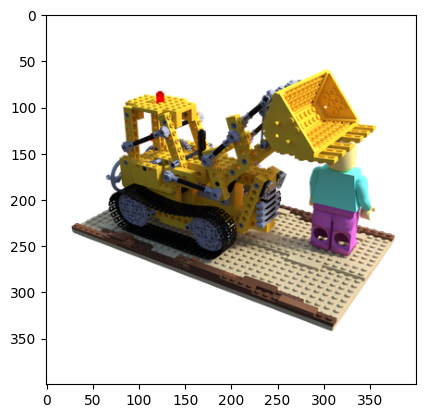

In [71]:
# # sample an image ...
# # 0 is unperturbed, others are perturbed
for i in [34]:
    sample = train_dataset[i]
    rays = sample['rays'].cuda()
    ts = sample['ts'].cuda()

    img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)

    plt.imshow(img_gt)

In [72]:

# import json
# with open(os.path.join(hparams.root_dir,
#                                f"transforms_train_windows.json"), 'r') as f:
#     data = json.load(f)
# # # # Load the JSON string into a dictionary
# # # # data = json.load(original_json)

# # # Modify the file_path values
# # i_ctr =0
# # ii_ctr=0
# # img_p_client=5
# for ind,frame in enumerate(data['frames']):
    
    
# #     ii_ctr+=1
#     orig_file=frame['file_path']#f"C:\\Users\\zaidt\\Desktop\\MediaLabs\\nerf\\blender_files\\res400_360view/r_{i_ctr:03d}"
#     mod_file=f"./train/r_{ind:d}"
# #     print("what i think: ",orig_file)
# #     print()
#     frame['file_path'] = frame['file_path'].replace(
#         orig_file,
#         mod_file
#     )
# #     i_ctr=i_ctr+3


# # Write the modified data back to the file
# with open('modified_file.json', 'w') as file:
#     json.dump(data, file, indent=4)

# print(modified_json)

In [73]:
# def calc_yaw(frame):
#     pose = np.array(frame['transform_matrix'])[:3, :4]
    
#      # Extract the 3x3 rotation matrix (R) from the 4x4 transformation matrix
#     rotation_matrix = pose[:3, :3]

#     # Calculate Euler angles (yaw, pitch, roll) from the rotation matrix
#     yaw = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
#     return yaw

In [74]:
# import numpy as np
# ## To sort in order of yaw
# import json
# with open(os.path.join(hparams.root_dir,
#                                f"transforms_train.json"), 'r') as f:
#     data = json.load(f)
# # Load the JSON string into a dictionary
# # data = json.load(original_json)

# # Sort the frames based on the "rotation" value
# data['frames'] = sorted(data['frames'], key=calc_yaw)

# # Write the modified data back to the file
# with open('modified_yaw_file.json', 'w') as file:
#     json.dump(data, file, indent=4)

# print(modified_json)

In [79]:
plot_public_model = False
server_round_ = 30
client_num = 19
# model_client = Net(hparams,train_dataset)
model_server = Net(hparams_central,train_dataset)
model_client = Net(hparams,train_dataset)

client_ckpt_file_transient = os.path.join(f'ckpts/{hparams.exp_name}/clients/client_{client_num:0>2d}/epoch_{server_round_:0>2d}.pth')
client_ckpt_file_static = os.path.join(f'ckpts/{hparams.exp_name}/clients-static/client_{client_num:0>2d}/epoch_{server_round_:0>2d}.pth')
server_ckpt_file = os.path.join(f"ckpts/{hparams_central.exp_name}/server/round_{server_round_}.pth")

if plot_public_model:
    hparams_public = copy.deepcopy(hparams)
    hparams_public.encode_t = True
    
    model_public = Net(hparams_public,train_dataset)
    
    public_ckpt_file_transient = os.path.join(f'ckpts/{hparams.exp_name}/central_model_transient.pth')
    public_ckpt_file_static = os.path.join(f'ckpts/{hparams.exp_name}/central_model_static40.pth')

    public_static_state_dict = torch.load(public_ckpt_file_static)
    public_transient_state_dict = torch.load(public_ckpt_file_transient)

    public_static_state_dict.update(public_transient_state_dict)
    
    model_public.load_state_dict(public_static_state_dict,strict=True)



client_state_dict =  torch.load(client_ckpt_file_static)
# print("Client static:  \n",server_state_dict.keys())
if hparams.encode_t:
    state_dict_transient = torch.load(client_ckpt_file_transient)
    # print("Client Trasient:  \n",state_dict_transient.keys())
    client_state_dict.update(state_dict_transient)
    # print("Client whole:  \n",server_state_dict.keys())
    beta_min = 0.1
model_client.load_state_dict(client_state_dict,strict=True)

server_state_dict= torch.load(server_ckpt_file)
model_server.load_state_dict(server_state_dict,strict=True)







<All keys matched successfully>

/tmp/ipykernel_115495/3381569363.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


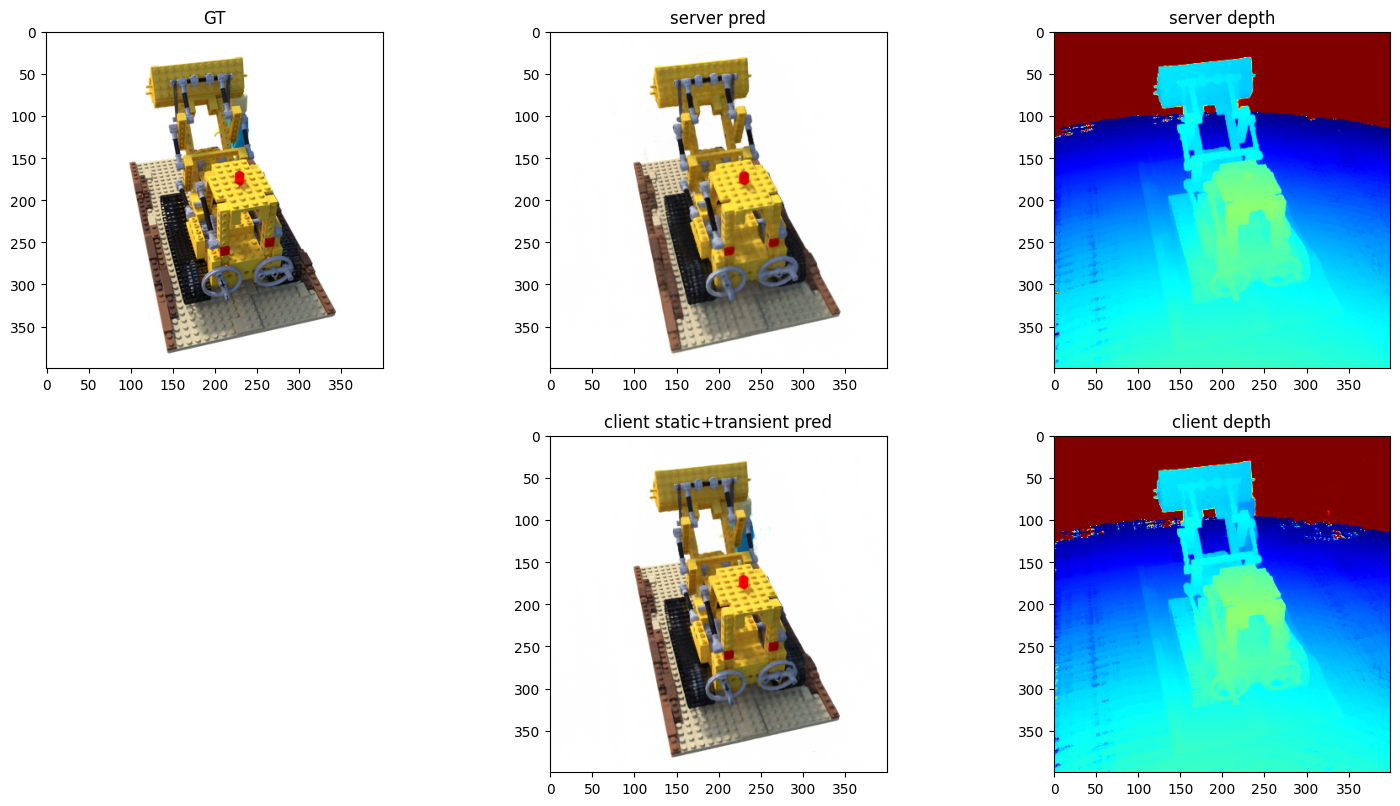

Server - PSNR between GT and pred: 25.604114532470703 

Client - PSNR between GT and pred: 31.479652404785156 



In [80]:
i=client_num*5+1
# i=5
sample = train_dataset[i]
rays = sample['rays'].to(device)
ts = sample['ts'].to(device)

model_server=model_server.to(device)
model_server_dict = {'coarse': model_server.nerf_coarse,'fine':model_server.nerf_fine}

model_client = model_client.to(device)
model_client_dict = {'coarse': model_client.nerf_coarse,'fine':model_client.nerf_fine}

results_server = f(rays, ts,model_server_dict,model_server)
img_pred_server = results_server['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred_server = results_server['depth_fine'].view(img_wh[1], img_wh[0])

results_client = f(rays, ts,model_client_dict,model_client)
img_pred_client = results_client['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred_client = results_client['depth_fine'].view(img_wh[1], img_wh[0])

img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(2,3,1)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(2,3,2)
plt.title('server pred')
plt.imshow(img_pred_server)
plt.subplot(2,3,3)
plt.title('server depth')
plt.imshow(visualize_depth(depth_pred_server).permute(1,2,0))
# plt.show()
plt.subplot(2,3,5)
plt.title('client static+transient pred')
plt.imshow(img_pred_client)
plt.subplot(2,3,6)
plt.title('client depth')
plt.imshow(visualize_depth(depth_pred_client).permute(1,2,0))
plt.show()

print('Server - PSNR between GT and pred:', metrics.psnr(img_gt, img_pred_server).item(), '\n')
print('Client - PSNR between GT and pred:', metrics.psnr(img_gt, img_pred_client).item(), '\n')

# print(results.keys())


if hparams.encode_t:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    img_gt_static = sample['original_rgbs'].view(img_wh[1], img_wh[0], 3)
    valid_mask_static = sample['original_valid_mask'].view(img_wh[1], img_wh[0])
    beta = results_client['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results_client['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results_client['rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results_client['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results_client['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(241)
    plt.title('original GT')
    plt.imshow(img_gt_static)
    plt.subplot(242)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(243)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(244)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray', vmax=beta_min/100)
    plt.subplot(245)
    plt.title('original valid mask')
    plt.imshow(valid_mask_static, cmap='gray')
    plt.subplot(246)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.subplot(247)
    plt.title('transient depth')
    plt.imshow(visualize_depth(depth_pred_transient).permute(1,2,0))
    plt.show()

    print('PSNR between original GT and static:',
          metrics.psnr(img_gt_static, img_pred_static).item())

# Validation Set

/tmp/ipykernel_115495/2767613654.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


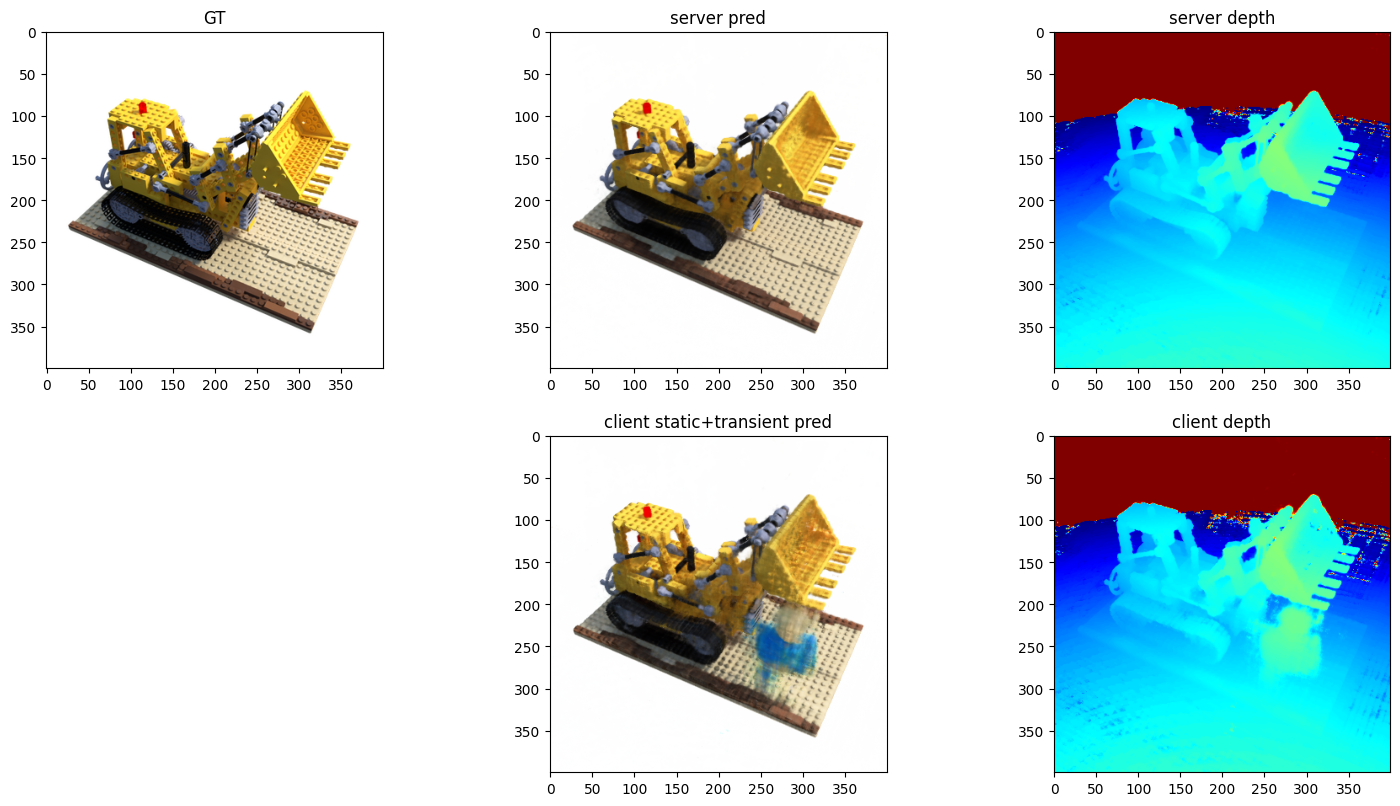

Server - PSNR between GT and pred: 26.23115348815918 

Client - PSNR between GT and pred: 19.70178985595703 



In [81]:


client_num*5+1
# i=5
sample = val_dataset[i]
rays = sample['rays'].to(device)
ts = sample['ts'].to(device)

model_server=model_server.to(device)
model_server_dict = {'coarse': model_server.nerf_coarse,'fine':model_server.nerf_fine}

model_client = model_client.to(device)
model_client_dict = {'coarse': model_client.nerf_coarse,'fine':model_client.nerf_fine}

results_server = f(rays, ts,model_server_dict,model_server)
img_pred_server = results_server['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred_server = results_server['depth_fine'].view(img_wh[1], img_wh[0])

results_client = f(rays, ts,model_client_dict,model_client)
img_pred_client = results_client['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred_client = results_client['depth_fine'].view(img_wh[1], img_wh[0])

img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(2,3,1)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(2,3,2)
plt.title('server pred')
plt.imshow(img_pred_server)
plt.subplot(2,3,3)
plt.title('server depth')
plt.imshow(visualize_depth(depth_pred_server).permute(1,2,0))
# plt.show()
plt.subplot(2,3,5)
plt.title('client static+transient pred')
plt.imshow(img_pred_client)
plt.subplot(2,3,6)
plt.title('client depth')
plt.imshow(visualize_depth(depth_pred_client).permute(1,2,0))
plt.show()

print('Server - PSNR between GT and pred:', metrics.psnr(img_gt, img_pred_server).item(), '\n')
print('Client - PSNR between GT and pred:', metrics.psnr(img_gt, img_pred_client).item(), '\n')

# print(results.keys())


if hparams.encode_t:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    img_gt_static = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
    valid_mask_static = sample['valid_mask'].view(img_wh[1], img_wh[0])
    beta = results_client['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results_client['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results_client['rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results_client['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results_client['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(241)
    plt.title('original GT')
    plt.imshow(img_gt_static)
    plt.subplot(242)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(243)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(244)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray', vmax=beta_min/100)
    plt.subplot(245)
    plt.title('original valid mask')
    plt.imshow(valid_mask_static, cmap='gray')
    plt.subplot(246)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.subplot(247)
    plt.title('transient depth')
    plt.imshow(visualize_depth(depth_pred_transient).permute(1,2,0))
    plt.show()

    print('PSNR between original GT and static:',
          metrics.psnr(img_gt_static, img_pred_static).item())

# Test on 63th val image (same as the image in the paper Fig 13)

In [51]:
perturbation = ['occ']

valdataset = dataset_dict['blender'] \
          ('/home/zt16/code/priv-nerf/nerf-pytorch/data/NeRF_Data/nerf_synthetic/lego/',
           split='val',
           perturbation=perturbation,
           img_wh=img_wh)

In [20]:
sample = valdataset[1]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts)

TypeError: f() missing 2 required positional arguments: 'model_' and 'model_params'

In [ ]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')

In [ ]:
if encode_transient:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    img_gt_static = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
    beta = results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(241)
    plt.title('original GT')
    plt.imshow(img_gt_static)
    plt.subplot(242)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(243)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(244)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray', vmax=beta_min/100)
    plt.subplot(245)
    plt.title('original valid mask')
    plt.imshow(valid_mask_static, cmap='gray')
    plt.subplot(246)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.subplot(247)
    plt.title('transient depth')
    plt.imshow(visualize_depth(depth_pred_transient).permute(1,2,0))
    plt.show()
    
    print('PSNR between original GT and static:',
          metrics.psnr(img_gt_static, img_pred_static).item())